In [100]:
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense
from tensorflow.keras.utils import plot_model
from keras.metrics import Recall, BinaryAccuracy,Precision

import os
import imghdr

In [101]:
# Limiting tensorflow on GPU usage
gpus = tf.config.experimental.list_physical_devices("GPU")
for i in gpus:
    tf.config.experimental.set_memory_growth(i, True)

## Cleaning data from bad image format

In [102]:
images_folder = "images"

In [103]:
image_ext = ["jpg", "png", "bmp", "jpeg"]

In [104]:
for image_class in os.listdir(images_folder):
    if not image_class == ".DS_Store":
        for image in os.listdir(os.path.join(images_folder,image_class)):
            img_path = os.path.join(images_folder, image_class, image)
            
            try:
                img = cv2.imread(img_path)
                ext = imghdr.what(img_path) # gets the file extenstion

                if not ext in image_ext:
                    print(f"Image extenstion is bad: {img_path}")
                    os.remove(img_path)
            except:
                print(f"Image could not be open: {img_path}")
                os.remove(img_path)

In [105]:
img = cv2.imread(os.path.join(images_folder, "happy", "1HEoLBLidT2u4mhJ0oiDgig.png"))
img

array([[[241, 249, 255],
        [241, 249, 255],
        [241, 249, 255],
        ...,
        [236, 244, 254],
        [236, 244, 254],
        [236, 244, 254]],

       [[241, 249, 255],
        [240, 248, 255],
        [239, 247, 255],
        ...,
        [237, 245, 255],
        [236, 244, 254],
        [236, 244, 254]],

       [[241, 249, 255],
        [240, 248, 255],
        [239, 247, 255],
        ...,
        [237, 245, 255],
        [236, 244, 254],
        [236, 244, 254]],

       ...,

       [[ 50,  83,  97],
        [ 62,  96, 107],
        [ 62,  96, 107],
        ...,
        [ 57,  92,  91],
        [ 49,  86,  82],
        [ 59,  95,  94]],

       [[ 68, 102, 114],
        [ 61,  95, 106],
        [ 64,  99, 109],
        ...,
        [ 54,  89,  87],
        [ 59,  95,  93],
        [ 50,  85,  86]],

       [[ 60,  94, 107],
        [ 62,  96, 109],
        [ 61,  95, 107],
        ...,
        [ 54,  87,  89],
        [ 57,  93,  94],
        [ 55,  89,  94]]

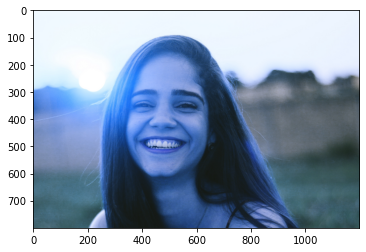

In [106]:
plt.imshow(img)

# Creating a dataframe of images

In [107]:
# getting our images as a dataset 
data = tf.keras.utils.image_dataset_from_directory(images_folder, batch_size=32)

Found 446 files belonging to 2 classes.


In [108]:
# Creating an iterator for our data
data_iterator = data.as_numpy_iterator()
data_iterator

In [109]:
# Actually getting the data
batch = data_iterator.next()
# bach[0] is features, batch[1] is labels

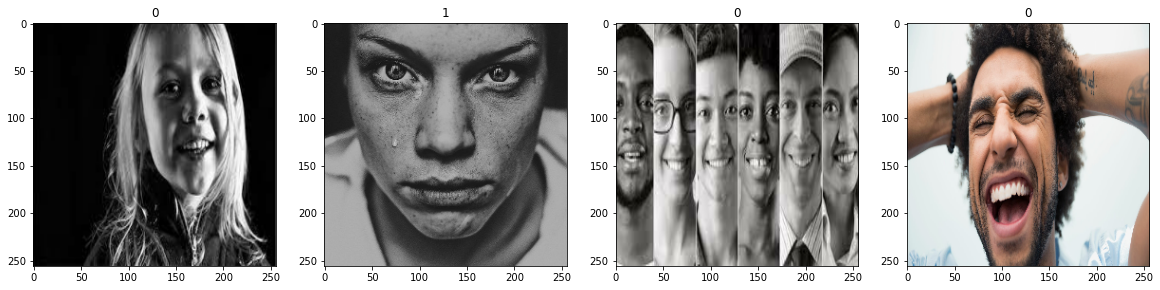

In [110]:
# Plotting images to see how they are labeled
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for i, img in enumerate(batch[0][:4]):
    ax[i].imshow(img.astype(int))
    ax[i].title.set_text(batch[1][i])

# 0 is happy
# 1 is sad

# Data Preprocessing

In [111]:
# Scaling our images, so that they are from 0.0 to 1.0 (done for performance purposes)
data = data.map(lambda x,y: (x/255, y))

In [112]:
batch = data.as_numpy_iterator().next()
batch[0].max()

1.0

## Splitting our data

In [113]:
# Getting the right size for our data
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)+1
test_size = int(len(data)*.1)+1

In [114]:
# Actually splitting our data
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# Buidling the model

In [115]:
# Set random seed
tf.random.set_seed(42)

# Create a model
model_1 = Sequential([
    Conv2D(16, (3,3), 1, activation="relu", input_shape=(256,256,3)),
    MaxPool2D(),

    Conv2D(32, (3,3), 1, activation="relu"),
    MaxPool2D(),

    Conv2D(16, (3,3), 1, activation="relu"),
    MaxPool2D(),

    Flatten(),
    Dense(256, activation="relu"),
    Dense(1, activation="sigmoid")
])

# Compile the model
model_1.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

In [116]:
model_1.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 127, 127, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 62, 62, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 30, 30, 16)      

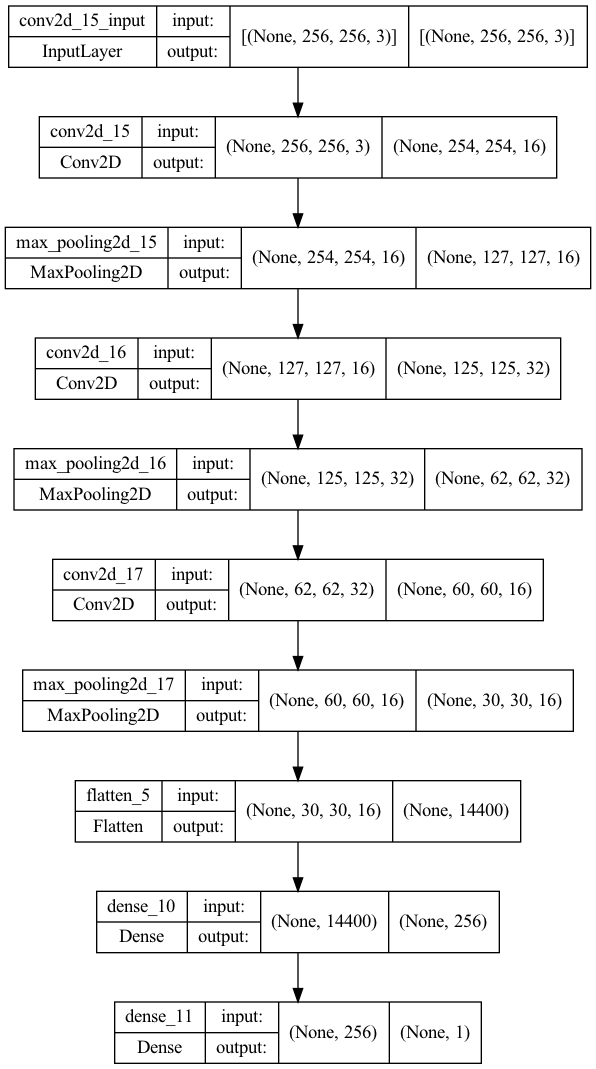

In [117]:
plot_model(model_1, show_shapes=True)

## Training our model

In [118]:
logdir = "logs"
tf_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [119]:
# Fitting our model
hist = model_1.fit(train, epochs=20, validation_data=val, callbacks=[tf_callback])

Epoch 1/20


2022-05-08 19:34:35.516755: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


9/9 [==============================] - ETA: 0s - loss: 1.0813 - accuracy: 0.4826

2022-05-08 19:34:40.243665: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


9/9 [==============================] - 9s 554ms/step - loss: 1.0813 - accuracy: 0.4826 - val_loss: 0.6826 - val_accuracy: 0.7500
Epoch 2/20
9/9 [==============================] - 6s 542ms/step - loss: 0.6458 - accuracy: 0.6111 - val_loss: 0.5820 - val_accuracy: 0.5625
Epoch 3/20
9/9 [==============================] - 6s 489ms/step - loss: 0.5490 - accuracy: 0.6771 - val_loss: 0.4550 - val_accuracy: 0.8333
Epoch 4/20
9/9 [==============================] - 6s 484ms/step - loss: 0.5020 - accuracy: 0.7882 - val_loss: 0.4025 - val_accuracy: 0.8438
Epoch 5/20
9/9 [==============================] - 6s 493ms/step - loss: 0.3980 - accuracy: 0.8576 - val_loss: 0.3316 - val_accuracy: 0.9062
Epoch 6/20
9/9 [==============================] - 6s 520ms/step - loss: 0.2979 - accuracy: 0.8958 - val_loss: 0.2187 - val_accuracy: 0.9583
Epoch 7/20
9/9 [==============================] - 6s 509ms/step - loss: 0.2188 - accuracy: 0.9340 - val_loss: 0.1558 - val_accuracy: 0.9271
Epoch 8/20
9/9 [===============

# Evaluating our model performance

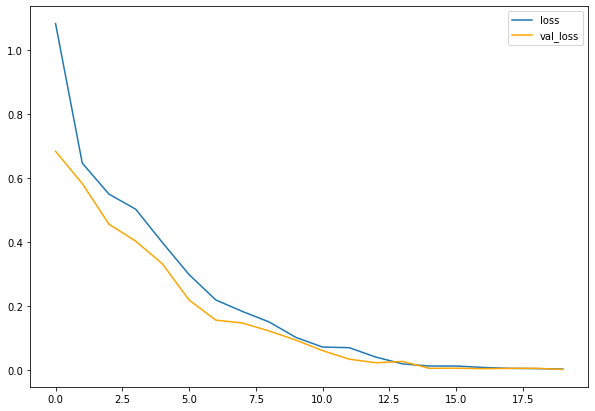

In [120]:
# Ploting our loss history
plt.figure(figsize=(10,7))
plt.plot(hist.history["loss"], label="loss")
plt.plot(hist.history["val_loss"], c="orange", label="val_loss")
plt.legend();


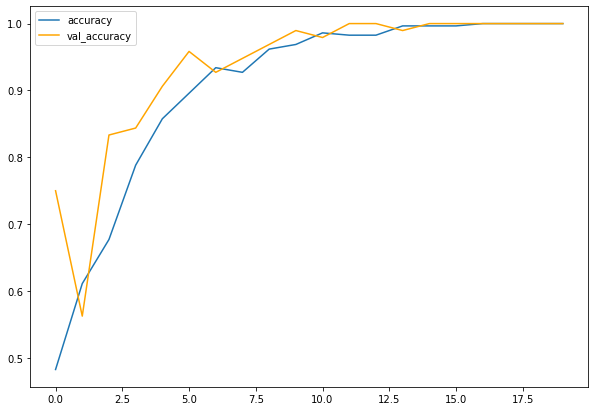

In [121]:
# Ploting our accuracy
plt.figure(figsize=(10,7))
plt.plot(hist.history["accuracy"], label="accuracy")
plt.plot(hist.history["val_accuracy"],c="orange", label="val_accuracy")
plt.legend();

In [122]:
precision = Precision()
recall = Recall()
binary_accuracy = BinaryAccuracy()

# Testing our model on test data
for i in test.as_numpy_iterator():
    X, y = i
    prediction = model_1.predict(X)
    precision.update_state(y, prediction)
    recall.update_state(y, prediction)
    binary_accuracy.update_state(y, prediction)

print(f"Precision: {precision.result().numpy()} \nRecall: {recall.result().numpy()} \nBinary Accuracy: {binary_accuracy.result().numpy()}")

2022-05-08 19:37:07.826822: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-08 19:37:09.326099: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Precision: 1.0 
Recall: 1.0 
Binary Accuracy: 1.0


# Predicting on real data

In [123]:
def classifyImage(img):
    test_img = cv2.imread(img)
    plt.imshow(cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB))
    plt.show()
    
    # Resizing the image
    resized = tf.image.resize(test_img, (256,256))

    # Actually classifying the image
    yhat = model_1.predict(tf.expand_dims(resized/255, axis=0))

    if yhat < .5:
        print("This is a happy image")
    if yhat > .5:
        print("This is a sad image")


# Saving the model

In [124]:
model_1.save("happySad_model.h5")